# Lab session 1: Gaussian Process models with GPy

Source: [Gaussian Process Summer School 2015](http://gpss.cc/gpss15/)

The aim of this lab session is to get us started with GPy Library. The current draft of the online documentation of GPy is available from [this page](http://gpy.readthedocs.org/en/latest/). We will focus on three aspects of GPs: the kernel, the random sample paths and the GP regression model.

Requirements:
* [GPy](https://github.com/SheffieldML/GPy): Installation instructions available on the homepage.
* [Scipy Stack](https://www.scipy.org/index.html): This includes numpy, matplotlib and Ipython. Installation can be done using `pip`:
```
(sudo) pip install numpy --upgrade
(sudo) pip install jupyter --upgrade
(sudo) pip install matplotlib --upgrade
(sudo) pip install ipython[all] --upgrade
```
The `sudo` is optional if you want to have installation in the root folder when working in the Linux operating system. It should not be used for Anaconda or when working in the Windows operating system.

* [Anaconda](https://www.continuum.io/downloads): Necessary for Windows, optional for Linux.

For Windows Operating System:
* Install Anaconda by downloading from this [link](https://www.continuum.io/downloads#windows).
* Install GPy by opening the Command Prompt window and typing the following command:
```
pip install GPy
```
* All the dependencies required for running the code are either available in Anaconda or installed using GPy.

In [1]:
# import python modules
import GPy
import numpy as np
from matplotlib import pyplot as plt

# call matplotlib with the inline command to make plots appear within the browser
%matplotlib inline

## 1 Covariance Functions

GPy supports a wide range of covariance functions. Each function is suitable for some applications. In this section, we work with the covariance functions in GPy. 

Let's start with defining an exponentiated quadratic covariance function (also known as squared exponential or rbf or Gaussian) in one dimension:
$$
k(\mathbf{x},\mathbf{x'}) = \sigma^2 \text{exp} \left( - \frac{\|\mathbf{x} - \mathbf{x'} \|}{2l^2} \right)
$$

In [2]:
# The documentation to use the RBF function. There are several advanced options such as useGPU which are 
# important for practical applications. The "?" symbol can be used with any function or class to view its
# documentation
GPy.kern.RBF?

In [9]:
# input dimension
d = 1          
# variance
var = 1.       
# lengthscale
length = 0.2

# define the kernel
k = GPy.kern.RBF(d, variance=var, lengthscale=length)

A summary of the kernel can be obtained using the command `print k`. 

In [10]:
print k

  rbf.         |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    0.2  |      +ve      |        


It is also possible to plot the kernel as a function of one of its inputs (whilst fixing the other) with `k.plot()`. Use "?" to view the properties of the plot function for `kern` instance.

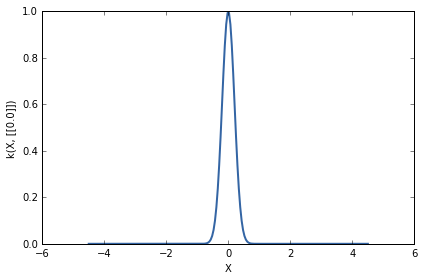

In [11]:
k.plot()

## Setting Covariance Function Parameters

The value of the covariance function parameters can be accessed and modified using `k['*']` where the string in bracket is a regular expression matching the parameter name as it appears in `print k`. Let's use this to get an insight into the effect of the parameters on the shape of the covariance function. 

We'll now use to set the lengthscale of the covariance to different values, and then plot the resulting covariance using the `k.plot()` method.

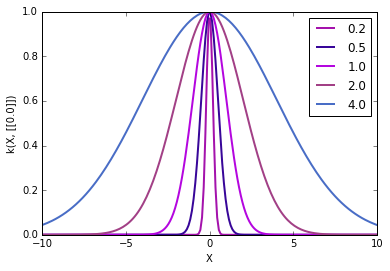

In [8]:
# by default, all the parameters are set to 1. for the RBF kernel
k = GPy.kern.RBF(d)     

# we experiment with different length scale parameter values here
theta = np.asarray([0.2,0.5,1.,2.,4.])

# create an instance of a figure
fig = plt.figure()
ax = plt.subplot(111)

# iterate over the lengthscales
for t in theta:
    k.lengthscale=t
    # plot in the same figure with a different color
    k.plot(ax=ax, color=np.random.rand(3,), plot_limits=[-10.0,10.0])
plt.legend(theta)

### Exercise 1

a) What is the effect of the lengthscale parameter on the covariance function?

b) Now change the code used above for plotting the covariances associated with the length scale to see the influence of the variance parameter. What is the effect of the the variance parameter on the covariance function?

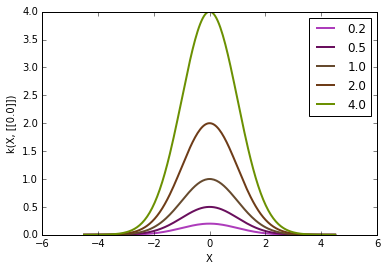

In [12]:
# by default, all the parameters are set to 1. for the RBF kernel
k = GPy.kern.RBF(d)     

# we experiment with different length scale parameter values here
var = np.asarray([0.2,0.5,1.,2.,4.])

# create an instance of a figure
fig = plt.figure()
ax = plt.subplot(111)

# iterate over the lengthscales
for v in var:
    k.variance = v
    # plot in the same figure with a different color
    k.plot(ax=ax, color=np.random.rand(3,))
plt.legend(var)

c) Instead of rbf, try constructing and plotting the following  covariance functions: `exponential`, `Matern32`, `Matern52`, `Brownian`, `linear`, `bias`, `rbfcos`, `periodic_Matern32`, etc. Use the `tab` key to look for the functions `GPy.kern` submodule or search in the [GPy documentation](http://pythonhosted.org/GPy/index.html).

  Mat32.       |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    1.0  |      +ve      |        


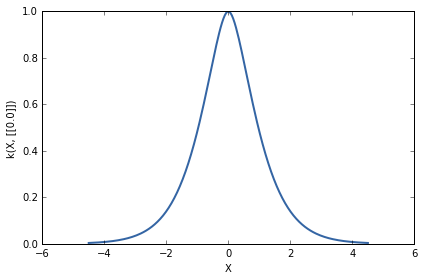

In [22]:
# look for the kernel documentation
GPy.kern.Matern32?

# input dim
d = 1

# create the Matern32 kernel
k = GPy.kern.Matern32(d)

# view the kernel
print k
k.plot()

## Computing the kernel matrix given input data, $\mathbf{X}$

Let $\mathbf{X}$ be a $n$ × $d$ numpy array. Given a kernel $k$, the covariance matrix associated to
$\mathbf{X}$ is obtained with `C = k.K(X,X)` . The positive semi-definiteness of $k$ ensures that `C`
is a positive semi-definite (psd) matrix regardless of the initial points $\mathbf{X}$. This can be
checked numerically by looking at the eigenvalues:

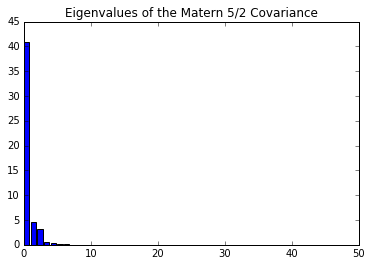

In [23]:
# input data: 50*2 matrix of iid standard Gaussians
X = np.random.rand(50,2)       

# create the matern52 kernel
k = GPy.kern.Matern52(input_dim=2)

# compute the kernel matrix
C = k.K(X,X)

# computes eigenvalues of matrix
eigvals = np.linalg.eigvals(C) 

# plot the eigen values
plt.bar(np.arange(len(eigvals)), eigvals)
plt.title('Eigenvalues of the Matern 5/2 Covariance')

## Combining Covariance Functions

In GPy you can easily combine covariance functions you have created using the sum and product operators, `+` and `*`. For example, we can combine an exponentiated quadratic covariance with a Matern 5/2 as follows:

  sum.               |  value  |  constraints  |  priors
  rbf.variance       |    1.0  |      +ve      |        
  rbf.lengthscale    |    2.0  |      +ve      |        
  Mat52.variance     |    2.0  |      +ve      |        
  Mat52.lengthscale  |    4.0  |      +ve      |        


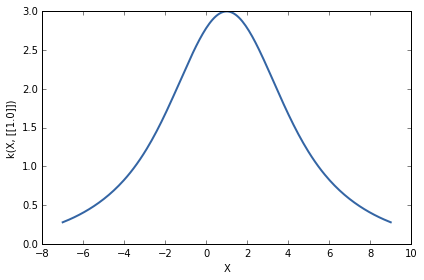

In [25]:
# define rbf and matern52 kernels
kern1 = GPy.kern.RBF(1, variance=1., lengthscale=2.)
kern2 = GPy.kern.Matern52(1, variance=2., lengthscale=4.)

# combine both kernels
kern = kern1 + kern2
print kern
kern.plot(plot_limits=[-7,9])

It is also possible to multiply two kernel functions:

  mul.               |  value  |  constraints  |  priors
  rbf.variance       |    1.0  |      +ve      |        
  rbf.lengthscale    |    2.0  |      +ve      |        
  Mat52.variance     |    2.0  |      +ve      |        
  Mat52.lengthscale  |    4.0  |      +ve      |        


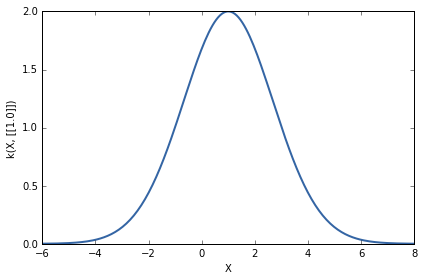

In [28]:
kern = kern1*kern2
print kern
kern.plot(plot_limits=[-6,8])

## 2 Sampling from a Gaussian Process

Gaussian process provides a prior over an infinite dimensional function. It is defined by a covariance *function* and a mean *function*. When we compute the covariance matrix using `kern.K(X, X)` i.e. compute a covariance *matrix* between the values of the function that correspond to the input locations in the matrix `X`. Using this we can draw sample paths from a Gaussian process:

$$
\mathbf{f} = \mathcal{N}(\mathbf{X}|\mathbf{0},C)
$$

 /usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: RuntimeWarning:covariance is not positive-semidefinite.


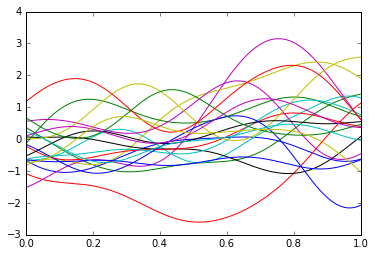

In [32]:
# define RBF kernel
k = GPy.kern.RBF(input_dim=1,lengthscale=0.2)

# define X to be 500 points evenly spaced over [0,1]
X = np.linspace(0.,1.,500) 

# make the numpy array to 2D array 
X = X[:,None] 

# set mean function i.e. 0 everywhere
mu = np.zeros((500)) 

# compute covariance matrix associated with inputs X
C = k.K(X,X) 

# Generate 20 separate samples paths from a Gaussian with mean mu and covariance C
Z = np.random.multivariate_normal(mu,C,20)

# open a new plotting window
fig = plt.figure()     
for i in range(20):
    plt.plot(X[:],Z[i,:])

We can see the structure of the covariance matrix we are plotting from if we visualize C.

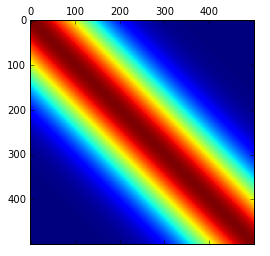

In [33]:
plt.matshow(C)

### Exercise 2

a) Try a range of different covariance functions and values to plot the corresponding sample paths for each using the same approach given above.

In [36]:
# Define input points and mean function
X = np.atleast_2d(np.linspace(0.,1.,500)).T
mu = np.zeros((500)) 

 /usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: RuntimeWarning:covariance is not positive-semidefinite.


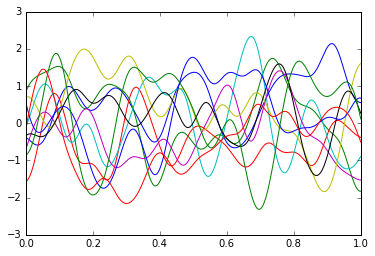

In [50]:
# sample paths for RBF kernel with different parameters
k = GPy.kern.RBF(input_dim=1,lengthscale=0.05)
C = k.K(X,X) 

# Generate 20 separate samples paths from a Gaussian with mean mu and covariance C
Z = np.random.multivariate_normal(mu,C,10)

# open a new plotting window
fig = plt.figure()     
for i in range(10):
    plt.plot(X[:],Z[i,:])

 /usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: RuntimeWarning:covariance is not positive-semidefinite.


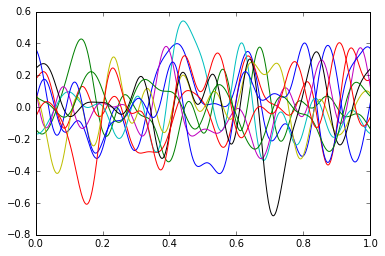

In [64]:
# sample paths for Matern32 kernel with different parameters
k = GPy.kern.PeriodicMatern52(input_dim=1, lengthscale=0.01, period=1)
C = k.K(X,X) 

# Generate 20 separate samples paths from a Gaussian with mean mu and covariance C
Z = np.random.multivariate_normal(mu,C,10)

# open a new plotting window
fig = plt.figure()     
for i in range(10):
    plt.plot(X[:],Z[i,:])

b) Can you tell the covariance structures that have been used for generating the
sample paths shown in the figure below?
<br>
<center>
<img src="http://ml.dcs.shef.ac.uk/gpss/gpws14/figa.png" alt="Figure a" style="width: 30%;"> 
<img src="http://ml.dcs.shef.ac.uk/gpss/gpws14/figb.png" alt="Figure b" style="width: 30%;"> 
<img src="http://ml.dcs.shef.ac.uk/gpss/gpws14/figd.png" alt="Figure d" style="width: 30%;">
</center>


## 3 Gaussian Process Regression Model

We will combine the Gaussian process prior with data to form a GP regression model with GPy. We will generate data from the function $f ( x ) = − \cos(\pi x ) + \sin(4\pi x )$ over $[0, 1]$, adding some noise to give $y(x) = f(x) + \epsilon$, with the noise being Gaussian distributed, $\epsilon \sim \mathcal{N}(0, 0.01)$. 

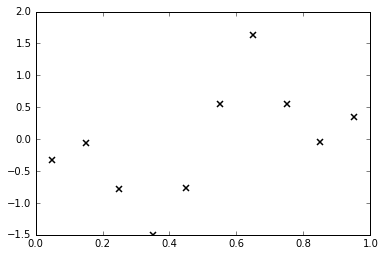

In [65]:
# input data points
X = np.linspace(0.05,0.95,10)[:,None]
# generate observations through function f
Y = -np.cos(np.pi*X) + np.sin(4*np.pi*X) + np.random.normal(loc=0.0, scale=0.1, size=(10,1)) 

# plot the generated data
plt.figure()
plt.plot(X,Y,'kx',mew=1.5)

A GP regression model is defined by first specifying the covariance function for analysis. Then an instance of the model is generated with a default set of parameters. Then it is possible to view the parameters using `print m` and visualize the posterior mean prediction and variances using `m.plot`:


Name : GP regression
Objective : 13.7373071015
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


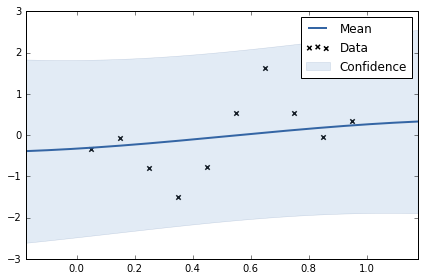

In [70]:
# create instance of kernel
k = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

# create instance of GP regression model
m = GPy.models.GPRegression(X,Y,k)

# view model parameters
print m

# visualize posterior mean and variances
m.plot()

The actual predictions of the model for a set of points `Xstar` can be computed using `m.predict(Xstar)`:

In [74]:
# obtain 5 test points
Xstar = np.linspace(0.01,0.99,5)[:,None]

# predict the output for the test points
Ystar, Vstar = m.predict(Xstar)

# print results
print Ystar

[[-0.32384729]
 [-0.19635731]
 [-0.03934559]
 [ 0.12045263]
 [ 0.25574702]]


### Exercise 3

a) What do you think about this first fit? Does the prior given by the GP seem to be
adapted?

b) The parameters of the models can be modified using a regular expression matching the parameters names (for example `m['noise'] = 0.001` ). Change the values of the parameters to obtain a better fit.


Name : GP regression
Objective : 27.8819693602
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    0.1  |      +ve      |        


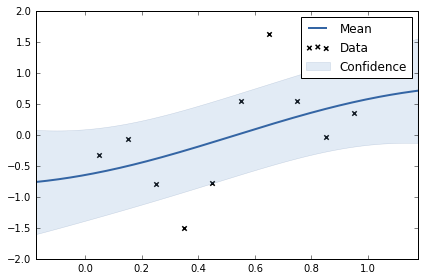

In [77]:
# set the noise parameter of the model using desired SNR
SNR = 10.0
m.Gaussian_noise.variance = m.rbf.variance/SNR

# check the model parameters and plot the model
print m
m.plot()

c) Random sample paths from the conditional GP can be obtained using `np.random.multivariate_normal(mu[:,0],C)` where the mean vector and covariance matrix `mu`, `C` are obtained through the predict function `mu, C = m.predict(Xp,full_cov=True)`. Obtain 10 samples from the posterior sample and plot them alongside the data below.

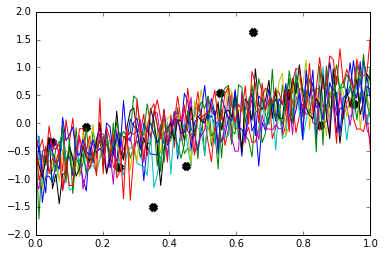

In [82]:
# get desired input points where model needs to be evaluated
Xp = np.linspace(0.0,1.0,100)[:,None]

# obtain posterior mean and variances
mu, C = m.predict(Xp, full_cov=True)

# generate 10 random paths of the distribution
nPaths = 10
paths = np.random.multivariate_normal(mu[:,0], C, nPaths)

# plot the dataset and the generated paths
plt.figure()
plt.plot(X,Y,'kx',mew=5)

for i in range(nPaths):
    plt.plot(Xp[:],paths[i,:])

### Covariance Function Parameter Estimation

The parameters values can be estimated by maximizing the likelihood of the observations. Since we don’t want one of the variance to become negative during the optimization, we can constrain all parameters to be positive before running the optimisation.

In [83]:
m.constrain_positive()

We can optimize the hyperparameters of the model using the `m.optimize()` method.


Name : GP regression
Objective : 8.9795911893
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |              value  |  constraints  |  priors
  rbf.variance             |     0.683314943552  |      +ve      |        
  rbf.lengthscale          |     0.104103710748  |      +ve      |        
  Gaussian_noise.variance  |  9.32391459571e-08  |      +ve      |        


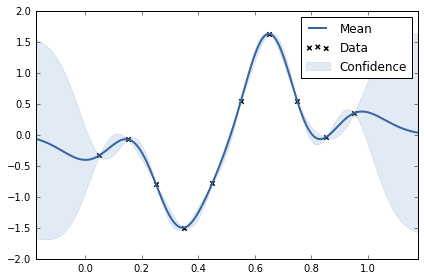

In [84]:
m.optimize()
m.plot()
print m

## Exercise 4

a) Generate random function samples using the optmized model and plot alongside the input data

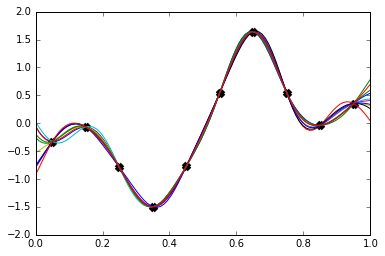

In [85]:
# get desired input points where model needs to be evaluated
Xp = np.linspace(0.0,1.0,100)[:,None]

# obtain posterior mean and variances
mu, C = m.predict(Xp, full_cov=True)

# generate 10 random paths of the distribution
nPaths = 10
paths = np.random.multivariate_normal(mu[:,0], C, nPaths)

# plot the dataset and the generated paths
plt.figure()
plt.plot(X,Y,'kx',mew=5)

for i in range(nPaths):
    plt.plot(Xp[:],paths[i,:])

b) Modify the kernel used for building the model to investigate its influence on the model


Name : GP regression
Objective : 9.81355151293
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |              value  |  constraints  |  priors
  Mat32.variance           |     0.738184446069  |      +ve      |        
  Mat32.lengthscale        |     0.144963111239  |      +ve      |        
  Gaussian_noise.variance  |  1.74750543008e-07  |      +ve      |        


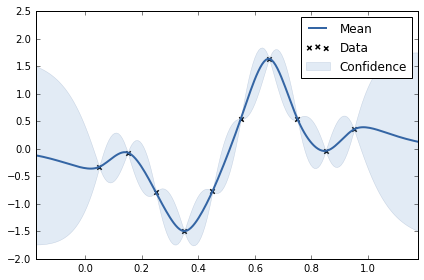

In [87]:
# create instance of kernel and GP Regression model
k = GPy.kern.Matern32(input_dim=1, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(X,Y,k)

# optimize the model
m.constrain_positive()
m.optimize()

# view model parameters
print m
m.plot()

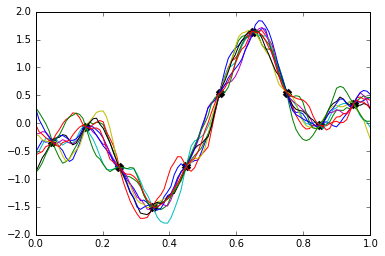

In [88]:
# get desired input points where model needs to be evaluated
Xp = np.linspace(0.0,1.0,100)[:,None]

# obtain posterior mean and variances
mu, C = m.predict(Xp, full_cov=True)

# generate 10 random paths of the distribution
nPaths = 10
paths = np.random.multivariate_normal(mu[:,0], C, nPaths)

# plot the dataset and the generated paths
plt.figure()
plt.plot(X,Y,'kx',mew=5)

for i in range(nPaths):
    plt.plot(Xp[:],paths[i,:])

## 4 A Running Example

Now we will consider a small example with real world data: data giving the pace of all marathons run at the olympics:

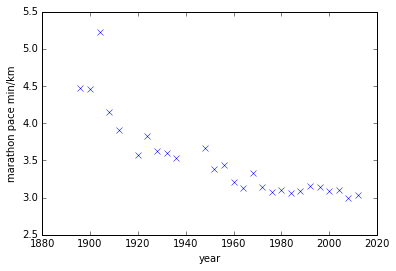

In [92]:
# load marathon timing dataset
data = np.genfromtxt('marathon.csv', delimiter=',')

# set the input and output data
X = data[:, 0:1]
Y = data[:, 1:2]

# plot the timings
plt.plot(X, Y, 'bx')
plt.xlabel('year')
plt.ylabel('marathon pace min/km')

### Exercise 5

a) Build a Gaussian process model for the olympic data set using a combination of an RBF and a bias covariance function. Fit the covariance function parameters and the noise to the data. Plot the fit and error bars from 1870 to 2030. Do you think the predictions are reasonable? If not why not?

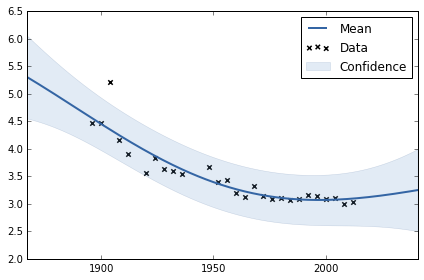

In [96]:
# create the covariance function
kern = GPy.kern.RBF(1) + GPy.kern.Bias(1)

# create the GP Regression model
model = GPy.models.GPRegression(X, Y, kern)

# optimize the model
model.optimize()
model.plot()

b) Fit the same model, but this time intialize the length scale of the RBF kernel to 0.5. What has happened? Which of model has the higher log likelihood, this one or the one from (a)? 

*Hint:* use `model.log_likelihood()` for computing the log likelihood.

-6.38254536348 -6.38254536304


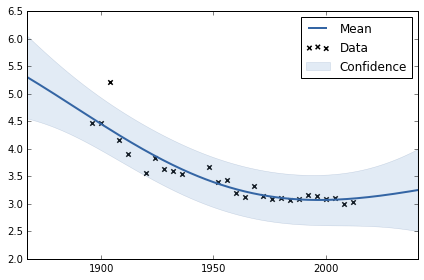

In [97]:
# create the covariance function and set the desired parameter values
kern2 = GPy.kern.RBF(1, variance=0.5) + GPy.kern.Bias(1)
model2 = GPy.models.GPRegression(X, Y, kern2)

# optimize and plot the model
model2.optimize()
model2.plot()

# compare the log likelihoods
print model.log_likelihood(), model2.log_likelihood()

c) Modify your model by including two covariance functions. Intitialize a covariance function with an exponentiated quadratic part, a Matern 3/2 part and a bias covariance. Set the initial lengthscale of the exponentiated quadratic to 80 years, set the initial length scale of the Matern 3/2 to 10 years. Optimize the new model and plot the fit again. How does it compare with the previous model? 

-6.38254536348 -5.99326857166


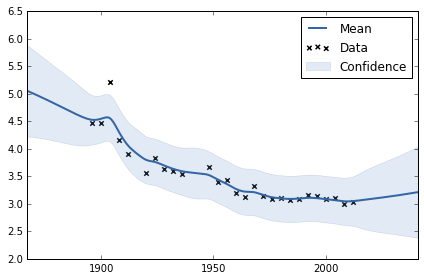

In [98]:
# create the covariance function and set the desired parameter values
kern3 = GPy.kern.RBF(1, lengthscale=80.0) + GPy.kern.Matern32(1, lengthscale=10.0) + GPy.kern.Bias(1)
model3 = GPy.models.GPRegression(X, Y, kern3)

# optimize and plot the model
model3.optimize()
model3.plot()

# compare the log likelihoods
print model.log_likelihood(), model3.log_likelihood()

d) Repeat part c) but now initialize both of the covariance functions' lengthscales to 20 years. Check the model parameters, what happens now? 

-5.99326857166 -5.99326857169


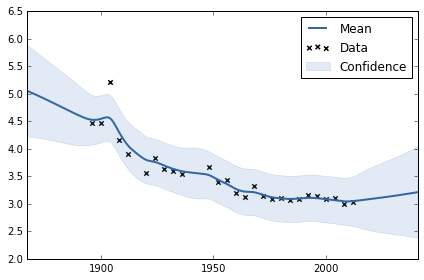

In [99]:
# create the covariance function and set the desired parameter values
kern4 = GPy.kern.RBF(1, lengthscale=20.0) + GPy.kern.Matern32(1, lengthscale=20.0) + GPy.kern.Bias(1)
model4 = GPy.models.GPRegression(X, Y, kern4)

# optimize and plot the model
model4.optimize()
model4.plot()

# compare the log likelihoods
print model3.log_likelihood(), model4.log_likelihood()

e) Now model the data with a product of an exponentiated quadratic covariance function and a linear covariance function. Fit the covariance function parameters. Why are the variance parameters of the linear part so small? How could this be fixed?


Name : GP regression
Objective : 7.156043678
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |              value  |  constraints  |  priors
  mul.rbf.variance         |      17.8040645203  |      +ve      |        
  mul.rbf.lengthscale      |      150.354296424  |      +ve      |        
  mul.linear.variances     |  3.96100131745e-07  |      +ve      |        
  Gaussian_noise.variance  |    0.0488438998867  |      +ve      |        
-6.38254536348 -7.156043678


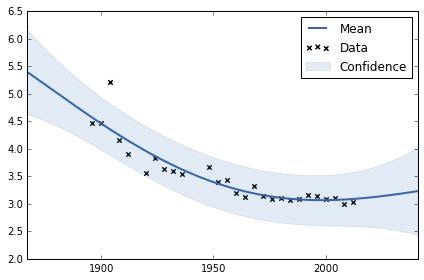

In [111]:
# create the covariance function and set the desired parameter values
kern5 = GPy.kern.RBF(1, lengthscale=5.0, variance=5.0)*GPy.kern.Linear(1)
model5 = GPy.models.GPRegression(X, Y, kern5)

# optimize and plot the model
model5.optimize()
model5.plot()

# get the model parameters
print model5

# compare the log likelihoods
print model.log_likelihood(), model5.log_likelihood()